# Importing necessary packages

In [51]:

import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import cv2
from glob import glob
from PIL import Image
from skimage.transform import resize
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
tf.random.set_seed(43)
np.random.seed(43)

### Converting filename to list

In [3]:
def listToString(s): 
    str1 = " " 
    return (str1.join(s))

In [4]:
path="../input/nvidiaai/training/training/background/"
pathfront='../input/nvidiaai/training/training/hi/'
file_list = os.listdir(path)
file_list1=os.listdir(pathfront)
print('Background')


Background


## Masking the image and converting it into grayscale for extracting fore-ground character

In [5]:

img1_mask= cv2.imread((pathfront+"dressingCase_6_c8_69_none_edgeEnhance.jpg"))
img1 = np.zeros((64,64,3))
equalizearray=np.equal(img1, img1_mask)
equalizearray=equalizearray.astype('float32')
grayscale = cv2.cvtColor(equalizearray, cv2.COLOR_BGR2GRAY)


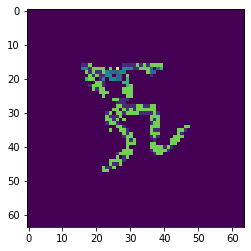

In [6]:
plt.imshow(grayscale)

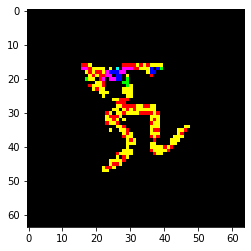

In [7]:
plt.imshow(equalizearray)

### Taking the image from directory and making dataframe with their corresponding label

In [8]:
data = {}
for subdirs, _, files in os.walk('../input/nvidiaai/training/training/hi'):
    for file in files:
        data[os.path.join(subdirs,file)] = int(str(file).split('_')[2][1:])

In [9]:
def parse_function(filename, label):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string)
    return image_decoded, label

def dataset_maker(dataset_type):

    filenames = tf.constant(list(dataset_type.keys()))
    labels = tf.constant(list(dataset_type.values()))

    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(parse_function)
    return dataset

training_dataset = dataset_maker(data)

In [10]:
list(training_dataset.as_numpy_iterator())[0]

(array([[[ 22,  49,   8],
         [ 28,  55,  14],
         [ 16,  43,   2],
         ...,
         [ 47,  72,  30],
         [ 63,  91,  30],
         [128, 160,  87]],
 
        [[ 79, 106,  65],
         [226, 253, 210],
         [  0,  21,   0],
         ...,
         [132, 158, 110],
         [ 12,  42,   0],
         [113, 146,  67]],
 
        [[ 73, 100,  57],
         [  2,  29,   0],
         [ 78, 105,  60],
         ...,
         [ 92, 121,  57],
         [ 15,  47,   0],
         [ 63,  98,   4]],
 
        ...,
 
        [[ 64,  93,  47],
         [155, 184, 136],
         [ 70,  98,  50],
         ...,
         [155, 176, 169],
         [196, 219, 209],
         [ 23,  46,  36]],
 
        [[ 47,  79,  30],
         [ 53,  85,  35],
         [ 24,  54,   4],
         ...,
         [200, 221, 214],
         [128, 151, 141],
         [121, 144, 134]],
 
        [[ 66, 100,  49],
         [ 63,  97,  46],
         [139, 171, 121],
         ...,
         [180, 201, 194],
  

In [11]:
set(data.values())

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}

In [12]:
str('../input/nvidiaai/training/training/hi/displayPanel_0_c11_67_flip_sharpen.jpg').split('_')[2][1:]

'11'

In [13]:
training_dataset

<MapDataset shapes: ((None, None, None), ()), types: (tf.uint8, tf.int32)>

## Makin training set with masking of each image

In [14]:
X_train = []
img1 = np.zeros((64,64,3))
for item in list(training_dataset.as_numpy_iterator()):
    
    equalizearray=np.equal(img1, item[::][0])
    equalizearray=equalizearray.astype('float32')
    grayscale = cv2.cvtColor(equalizearray, cv2.COLOR_BGR2GRAY)
    X_train.append(grayscale)
    
y_train=list(data.values())

8

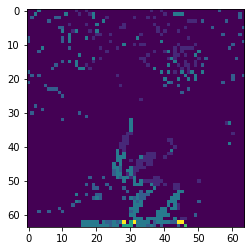

In [15]:
plt.imshow(X_train[0][:])
y_train[0]

In [16]:

X_train=np.asarray(X_train)
X_train=X_train.reshape(1425,64,64,1)

In [17]:
y_train=np.asarray(y_train)
y_train=to_categorical(y_train)


In [18]:
y_train.shape

(1425, 12)

In [19]:
X_train.shape

(1425, 64, 64, 1)

## Making the model with tensorflow modules

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten

In [21]:
model=Sequential()
model.add(Conv2D(filters=16,kernel_size=(2,2),
                 input_shape=(64,64,1),activation='relu'))

model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())

model.add(Dense(100,activation='relu'))


#output layer SOFTMAX-->MULTI CLASS
model.add(Dense(12,activation='softmax'))

model.compile(loss='categorical_crossentropy',optimizer='adam',
             metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 63, 63, 16)        80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 15376)             0         
_________________________________________________________________
dense (Dense)                (None, 100)               1537700   
_________________________________________________________________
dense_1 (Dense)              (None, 12)                1212      
Total params: 1,538,992
Trainable params: 1,538,992
Non-trainable params: 0
_________________________________________________________________


In [22]:
early_stop=EarlyStopping(monitor='val_loss',patience=1)

In [23]:
model.fit(X_train,y_train,epochs=25,callbacks=[early_stop])

Epoch 1/25
45/45 [==============================] - 7s 4ms/step - loss: 2.5090 - accuracy: 0.0994
Epoch 2/25
45/45 [==============================] - 0s 4ms/step - loss: 2.1910 - accuracy: 0.3260
Epoch 3/25
45/45 [==============================] - 0s 4ms/step - loss: 1.6174 - accuracy: 0.5673
Epoch 4/25
45/45 [==============================] - 0s 4ms/step - loss: 1.0045 - accuracy: 0.7609
Epoch 5/25
45/45 [==============================] - 0s 4ms/step - loss: 0.6179 - accuracy: 0.8799
Epoch 6/25
45/45 [==============================] - 0s 3ms/step - loss: 0.3791 - accuracy: 0.9378
Epoch 7/25
45/45 [==============================] - 0s 3ms/step - loss: 0.2344 - accuracy: 0.9676
Epoch 8/25
45/45 [==============================] - 0s 3ms/step - loss: 0.1682 - accuracy: 0.9769
Epoch 9/25
45/45 [==============================] - 0s 3ms/step - loss: 0.1276 - accuracy: 0.9803
Epoch 10/25
45/45 [==============================] - 0s 3ms/step - loss: 0.3801 - accuracy: 0.9429
Epoch 11/25
45/45 [

In [24]:
metrics=pd.DataFrame(model.history.history)

In [25]:
metrics

,loss,accuracy
0,2.479713,0.115789
1,2.131008,0.332632
2,1.537154,0.571930
3,0.963079,0.758596
4,0.582232,0.877895
5,0.347955,0.945263
6,0.225749,0.967018
7,0.156560,0.978246
8,0.166033,0.969123
9,0.343270,0.938947


<AxesSubplot:>

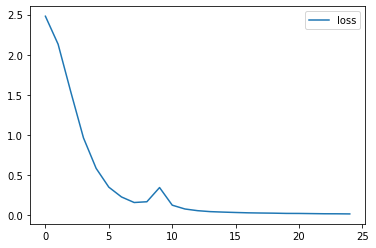

In [26]:
metrics[['loss']].plot()

# Checking with validation set and defining pre processing function

In [27]:
def file_to_imgarray(train):
    img_train = []
    img1 = np.zeros((64,64,3))
    for item in list(train):
        img1_mask= cv2.imread((item))
        equalizearray=np.equal(img1, img1_mask)
        equalizearray=equalizearray.astype('float32')
        grayscale = cv2.cvtColor(equalizearray, cv2.COLOR_BGR2GRAY)
        img_train.append(grayscale)
    
    return np.expand_dims(np.array(img_train), axis=3)

In [28]:
df = pd.DataFrame(data.items(), columns=['filename', 'label'])

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(df['filename'], df['label'], test_size=0.2, random_state=43)

In [30]:
X_train = file_to_imgarray(X_train)
X_val = file_to_imgarray(X_val)
y_val=to_categorical(y_val)
y_train=to_categorical(y_train)

In [31]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1140, 64, 64, 1), (285, 64, 64, 1), (1140, 12), (285, 12))

In [32]:
model.fit(X_train,y_train,epochs=15,validation_data=(X_val,y_val))

Epoch 1/15
36/36 [==============================] - 1s 19ms/step - loss: 0.1335 - accuracy: 0.9640 - val_loss: 0.1699 - val_accuracy: 0.9474
Epoch 2/15
36/36 [==============================] - 0s 5ms/step - loss: 0.3846 - accuracy: 0.9053 - val_loss: 0.3625 - val_accuracy: 0.8807
Epoch 3/15
36/36 [==============================] - 0s 5ms/step - loss: 0.2057 - accuracy: 0.9588 - val_loss: 0.5233 - val_accuracy: 0.8561
Epoch 4/15
36/36 [==============================] - 0s 5ms/step - loss: 0.0806 - accuracy: 0.9842 - val_loss: 0.4576 - val_accuracy: 0.8737
Epoch 5/15
36/36 [==============================] - 0s 5ms/step - loss: 0.0396 - accuracy: 0.9930 - val_loss: 0.4346 - val_accuracy: 0.8632
Epoch 6/15
36/36 [==============================] - 0s 4ms/step - loss: 0.1126 - accuracy: 0.9807 - val_loss: 0.5493 - val_accuracy: 0.8842
Epoch 7/15
36/36 [==============================] - 0s 5ms/step - loss: 0.0542 - accuracy: 0.9886 - val_loss: 0.4140 - val_accuracy: 0.8632
Epoch 8/15
36/36 [=

In [33]:
model.save('hindi_character_model.h5')

In [34]:
test_path='../input/nvidiaai/test/test'
from PIL import Image
import glob
image_list = []
for filename in glob.glob('../input/nvidiaai/test/test/*.jpg'): #assuming gif
    im=Image.open(filename)
    image_list.append(im)

In [35]:

testing=os.listdir(test_path)

In [36]:
X_test=file_to_imgarray(testing)

In [37]:
X_test.shape

(98, 64, 64, 1)

# Preprocess

In [38]:
predictions=np.argmax(model.predict(X_test), axis=-1)

In [47]:
len(predictions)

98

# Giving the result in json format for submission

In [50]:
import random
import json
# from utils.io import write_json

def write_json(filename, result):
    with open(filename, 'w') as outfile:
        json.dump(result, outfile)

def read_json(filename):
    with open(filename, 'r') as outfile:
        data =  json.load(outfile)
    return data

def generate_sample_file(filename):
    res = {}
    for i in range(1,98):
        test_set = str(i) + '.png'
        res[test_set] = int(predictions[i])

    write_json(filename, res)

if __name__ == '__main__':
    generate_sample_file('./sample_result1.json')